### This notebook was used to convert the original GPD weights to SeisBench and ensure binary compatibility. It is not intended for further use, but only serves as a reference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seisbench.models import GPD
from keras.models import model_from_json
from keras.utils import plot_model
import keras.backend as K
import numpy as np
import torch

Using TensorFlow backend.


In [3]:
model = GPD(original_compatible=True)

In [4]:
with open("../../generalized-phase-detection/model_pol.json", "r") as f:
    tf_model = model_from_json(f.read())

tf_model.load_weights("../../generalized-phase-detection/model_pol_best.hdf5")
tf_model = tf_model.layers[4]

In [5]:
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 32)           2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           30784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 64)           256       
_________________________________________________________________
activation_2 (Activation)    (None, 200, 64)          

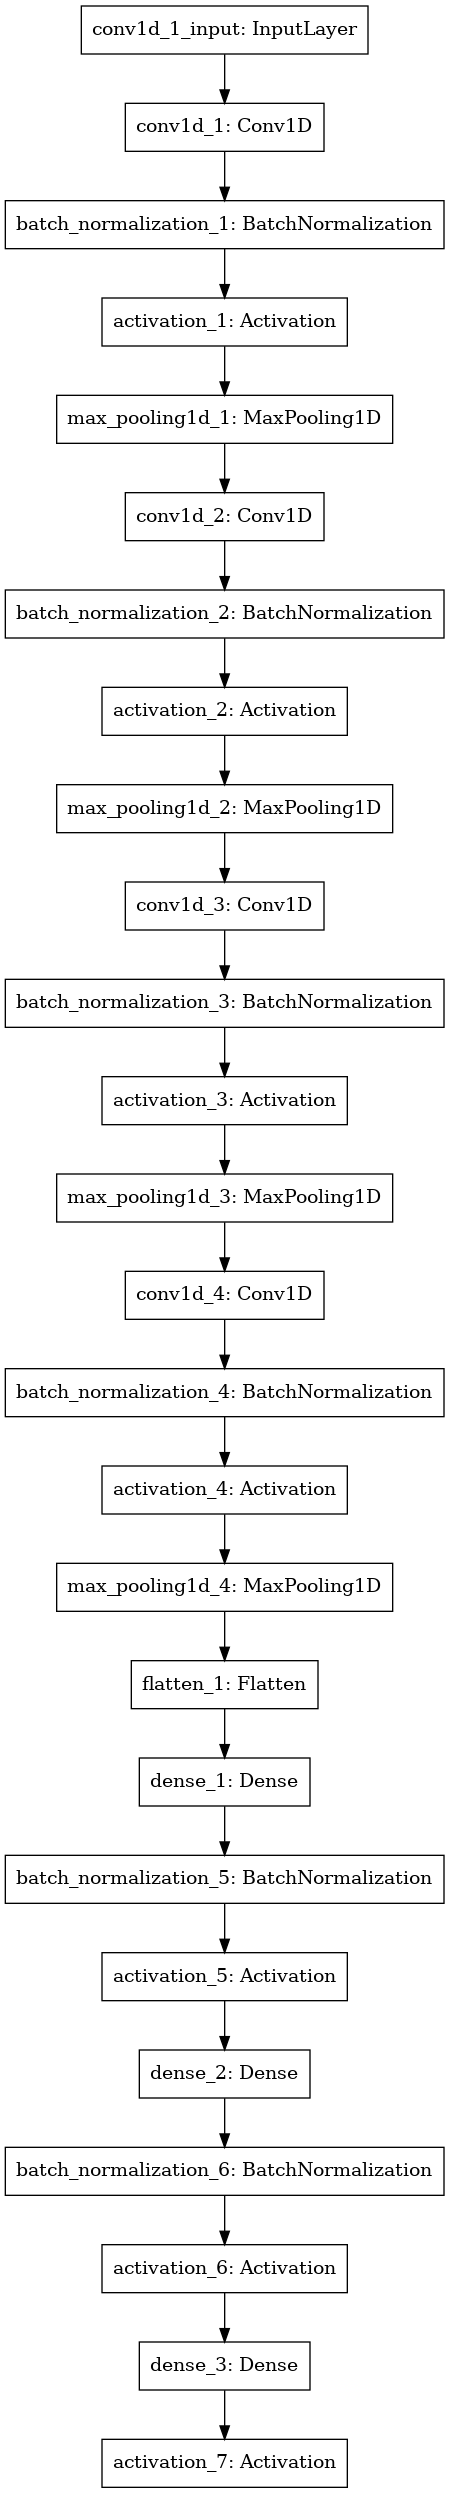

In [6]:
plot_model(tf_model, to_file="gpd.png")

In [7]:
tf_state_dict = {x.name: x.numpy() for x in tf_model.weights}

In [8]:
for key, val in model.state_dict().items():
    print(key, tuple(val.shape))

conv1.weight (32, 3, 21)
conv1.bias (32,)
bn1.weight (32,)
bn1.bias (32,)
bn1.running_mean (32,)
bn1.running_var (32,)
bn1.num_batches_tracked ()
conv2.weight (64, 32, 15)
conv2.bias (64,)
bn2.weight (64,)
bn2.bias (64,)
bn2.running_mean (64,)
bn2.running_var (64,)
bn2.num_batches_tracked ()
conv3.weight (128, 64, 11)
conv3.bias (128,)
bn3.weight (128,)
bn3.bias (128,)
bn3.running_mean (128,)
bn3.running_var (128,)
bn3.num_batches_tracked ()
conv4.weight (256, 128, 9)
conv4.bias (256,)
bn4.weight (256,)
bn4.bias (256,)
bn4.running_mean (256,)
bn4.running_var (256,)
bn4.num_batches_tracked ()
fc1.weight (200, 6400)
fc1.bias (200,)
bn5.weight (200,)
bn5.bias (200,)
bn5.running_mean (200,)
bn5.running_var (200,)
bn5.num_batches_tracked ()
fc2.weight (200, 200)
fc2.bias (200,)
bn6.weight (200,)
bn6.bias (200,)
bn6.running_mean (200,)
bn6.running_var (200,)
bn6.num_batches_tracked ()
fc3.weight (3, 200)
fc3.bias (3,)


In [9]:
for key, val in tf_state_dict.items():
    print(key, val.shape)

conv1d_1/kernel:0 (21, 3, 32)
conv1d_1/bias:0 (32,)
batch_normalization_1/gamma:0 (32,)
batch_normalization_1/beta:0 (32,)
conv1d_2/kernel:0 (15, 32, 64)
conv1d_2/bias:0 (64,)
batch_normalization_2/gamma:0 (64,)
batch_normalization_2/beta:0 (64,)
conv1d_3/kernel:0 (11, 64, 128)
conv1d_3/bias:0 (128,)
batch_normalization_3/gamma:0 (128,)
batch_normalization_3/beta:0 (128,)
conv1d_4/kernel:0 (9, 128, 256)
conv1d_4/bias:0 (256,)
batch_normalization_4/gamma:0 (256,)
batch_normalization_4/beta:0 (256,)
dense_1/kernel:0 (6400, 200)
dense_1/bias:0 (200,)
batch_normalization_5/gamma:0 (200,)
batch_normalization_5/beta:0 (200,)
dense_2/kernel:0 (200, 200)
dense_2/bias:0 (200,)
batch_normalization_6/gamma:0 (200,)
batch_normalization_6/beta:0 (200,)
dense_3/kernel:0 (200, 3)
dense_3/bias:0 (3,)
batch_normalization_1/moving_mean:0 (32,)
batch_normalization_1/moving_variance:0 (32,)
batch_normalization_2/moving_mean:0 (64,)
batch_normalization_2/moving_variance:0 (64,)
batch_normalization_3/moving

In [11]:
new_state_dict = {}

norm_dict = {
    "weight": "gamma",
    "bias": "beta",
    "running_mean": "moving_mean",
    "running_var": "moving_variance",
}

for key in model.state_dict():
    if key.startswith("conv"):
        layer, t = key.split(".")
        conv_id = layer[-1]
        source = f"conv1d_{conv_id}/"

        if t == "weight":
            data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
            # For input layer, resort channels from NEZ to ZNE
            if conv_id == "1":
                print("NEZ -> ZNE")
                data = data[:, [2, 0, 1], :]
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
        else:
            raise ValueError("Invalid t in conv")

    elif key.startswith("bn"):
        layer, t = key.split(".")
        bn_id = layer[-1]
        if t == "num_batches_tracked":
            data = model.state_dict()[key]
        else:
            source = f"batch_normalization_{bn_id}/{norm_dict[t]}:0"
            data = tf_state_dict[source]

    elif key.startswith("fc"):
        layer, t = key.split(".")
        fc_id = layer[-1]
        source = f"dense_{fc_id}/"

        if t == "weight":
            data = tf_state_dict[source + "kernel:0"].T
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
        else:
            raise ValueError("Invalid t in conv")

    else:
        raise ValueError("Unknown layer")

    new_state_dict[key] = torch.tensor(data)

NEZ -> ZNE


/home/munchmej/anaconda3/envs/eqtransformer/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
for key in new_state_dict.keys():
    if model.state_dict()[key].shape != new_state_dict[key].shape:
        print(key, pt_state_dict[key].shape, new_state_dict[key].shape)

In [13]:
assert len(new_state_dict) == len(model.state_dict())

In [14]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [15]:
torch.save(model.state_dict(), "/home/munchmej/.seisbench/models/gpd/original.pt")

In [16]:
wv = np.random.rand(1, 3, 400)
wv = wv / (np.max(wv, axis=(1, 2), keepdims=True) + 1e-10)

In [17]:
# With a Keras function
get_all_layer_outputs = K.function(
    [tf_model.layers[0].input] + [K.learning_phase()],
    [l.output for l in tf_model.layers],
)

layer_output = get_all_layer_outputs(
    [np.transpose(wv[:, [1, 2, 0]], (0, 2, 1))] + [0]
)  # return the same thing
layer_names = [x.name for x in tf_model.layers]

In [18]:
layer_names

['conv1d_1',
 'batch_normalization_1',
 'activation_1',
 'max_pooling1d_1',
 'conv1d_2',
 'batch_normalization_2',
 'activation_2',
 'max_pooling1d_2',
 'conv1d_3',
 'batch_normalization_3',
 'activation_3',
 'max_pooling1d_3',
 'conv1d_4',
 'batch_normalization_4',
 'activation_4',
 'max_pooling1d_4',
 'flatten_1',
 'dense_1',
 'batch_normalization_5',
 'activation_5',
 'dense_2',
 'batch_normalization_6',
 'activation_6',
 'dense_3',
 'activation_7']

In [19]:
layerid = 16
print(layer_names[layerid])

flatten_1


In [20]:
model.eval()
with torch.no_grad():
    out = model(torch.tensor(wv, dtype=torch.float32))
out = out.numpy()

In [21]:
out

array([[  6.13558397e-04,   1.86843507e-04,   9.99199569e-01]], dtype=float32)

In [22]:
layer_output[-1]

array([[  6.13557233e-04,   1.86842619e-04,   9.99199569e-01]], dtype=float32)